# Data Setup

In [1]:
import os

print(os.environ.get('CONDA_DEFAULT_ENV'))

period


In [2]:
import joblib
import os
import numpy as np
import torch
from evaluate import load
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import PretrainedConfig
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class MachoDataset(Dataset):
    def __init__(self, data_root, prediction_length, mode='train'):
        data = joblib.load(data_root + f'{mode}.pkl')
        self.prediction_length = prediction_length
        
        self.times = data[0][:, 0, :]
        self.values = data[0][:, 1, :]
        self.aux = data[1]
        self.labels = data[2]
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        past_times = torch.tensor(self.times[idx, :-self.prediction_length], dtype=torch.float)
        future_times = torch.tensor(self.times[idx, -self.prediction_length:], dtype=torch.float)
        past_values = torch.tensor(self.values[idx, :-self.prediction_length], dtype=torch.float)
        future_values = torch.tensor(self.values[idx, -self.prediction_length:], dtype=torch.float)
        past_mask = torch.ones(past_times.shape, dtype=torch.float)
        future_mask = torch.ones(future_times.shape, dtype=torch.float)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)

        past_times = past_times.unsqueeze(-1)
        future_times = future_times.unsqueeze(-1)

        return past_times, future_times, past_values, future_values, past_mask, future_mask, labels

In [4]:
data_root = '/home/mrizhko/AstroML/contra_periodic/data/macho/'
window_length = 200
prediction_length = 1

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
train_dataset = MachoDataset(data_root, prediction_length, mode='train')
val_dataset = MachoDataset(data_root, prediction_length, mode='val')
test_dataset = MachoDataset(data_root, prediction_length, mode='test')

In [7]:
len(train_dataset)

48047

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [9]:
past_times, future_times, past_values, future_values, past_mask, future_mask, labels = train_dataset[0]

# Time Series Prediction Model Setup

In [10]:
def train_step(train_dataloader, model, optimizer):
    total_loss = []
    
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        past_times, future_times, past_values, future_values, past_mask, future_mask, _ = batch
        
        outputs = model(
            past_time_features=past_times.to(device),
            past_values=past_values.to(device),
            future_time_features=future_times.to(device),
            future_values=future_values.to(device),
            past_observed_mask=past_mask.to(device),
            future_observed_mask=future_mask.to(device),
        )

        loss = outputs.loss
        total_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    return sum(total_loss) / len(total_loss)

In [11]:
def val_step(val_dataloader, model):
    total_loss = []

    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            past_times, future_times, past_values, future_values, past_mask, future_mask, _ = batch
            
            outputs = model(
                past_time_features=past_times.to(device),
                past_values=past_values.to(device),
                future_time_features=future_times.to(device),
                future_values=future_values.to(device),
                past_observed_mask=past_mask.to(device),
                future_observed_mask=future_mask.to(device),
            )
        
            loss = outputs.loss
            total_loss.append(loss.item())
            
    return sum(total_loss) / len(total_loss)

In [12]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=window_length - prediction_length - 7,    # 7 is max(lags) for default lags
    num_time_features=1,
    encoder_layers=2,
    decoder_layers=2,
    d_model=64,
)

model = TimeSeriesTransformerForPrediction(config)

In [13]:
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [14]:
train_losses, val_losses = [], []

for epoch in range(10):
    model.train()
    train_loss = train_step(train_dataloader, model, optimizer)
    train_losses.append(train_loss)

    model.eval()
    val_loss = val_step(val_dataloader, model)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch}: Train Loss {round(train_loss, 4)} Val Loss {round(val_loss, 4)}')

Epoch 0: Train Loss 0.9926 Val Loss 0.8771
Epoch 1: Train Loss 0.8743 Val Loss 0.8446
Epoch 2: Train Loss 0.8315 Val Loss 0.8007
Epoch 3: Train Loss 0.8134 Val Loss 0.7903
Epoch 4: Train Loss 0.8058 Val Loss 0.7902
Epoch 5: Train Loss 0.7883 Val Loss 0.757
Epoch 6: Train Loss 0.7843 Val Loss 0.7542
Epoch 7: Train Loss 0.7755 Val Loss 0.7522
Epoch 8: Train Loss 0.7713 Val Loss 0.7471
Epoch 9: Train Loss 0.7697 Val Loss 0.7457


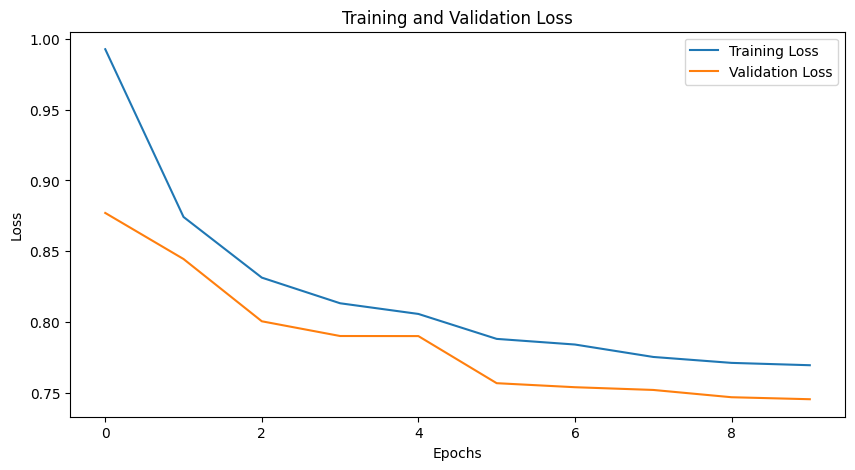

In [15]:
epochs = range(10)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
model.save_pretrained('weights/model.ckpt')

# Time Series Prediction Model Evaluation

In [17]:
def get_forecasts(model, val_dataloader):
    forecasts = []

    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            past_times, future_times, past_values, future_values, past_mask, future_mask, label = batch
            
            outputs = model.generate(
                past_time_features=past_times.to(device),
                past_values=past_values.to(device),
                future_time_features=future_times.to(device),
                past_observed_mask=past_mask.to(device),
            )
            
            forecasts.append(outputs.sequences.cpu().numpy())
    
    forecasts = np.vstack(forecasts)
    forecast_median = np.median(forecasts, 1)

    return forecast_median

In [18]:
def get_metrics(val_dataset, forecasts):
    mase_metric = load('evaluate-metric/mase')
    smape_metric = load('evaluate-metric/smape')
    
    mase_metrics = []
    smape_metrics = []
    
    for i, ts in enumerate(tqdm(val_dataset)):
        _, _, past_values, future_values, _, _, _ = val_dataset[i]
    
        mase = mase_metric.compute(
            predictions=forecasts[i],
            references=np.array(future_values),
            training=np.array(past_values)
        )
        mase_metrics.append(mase['mase'])
    
        smape = smape_metric.compute(
            predictions=forecasts[i],
            references=np.array(future_values),
        )
        smape_metrics.append(smape['smape'])

    return np.mean(mase_metrics), np.mean(smape_metrics)

In [19]:
model = TimeSeriesTransformerForPrediction.from_pretrained('weights/model.ckpt')
model = model.to(device)

In [20]:
model.eval()

forecasts = get_forecasts(model, val_dataloader)
mase, smape = get_metrics(val_dataset, forecasts)

print(f'MASE: {mase} sMAPE: {smape}')

100%|████████████████████████████████████| 16014/16014 [06:20<00:00, 42.06it/s]

MASE: 0.7628355321707666 sMAPE: 0.8248582315575865


# Classification Model

In [21]:
class ClassificationModel(nn.Module):
    def __init__(self, pretrained_model_path, device, hidden_size=64, num_labels=8):
        super(ClassificationModel, self).__init__()

        self.pretrained_model = TimeSeriesTransformerForPrediction.from_pretrained(pretrained_model_path)
        self.pretrained_model.to(device)
        self.device = device
        
        # for param in self.pretrained_model.parameters():
        #     param.requires_grad = False
            
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.classifier.to(self.device)
        
    def forward(self, past_times, past_values, future_times, past_mask):   
        outputs = self.pretrained_model(
            past_time_features=past_times.to(self.device),
            past_values=past_values.to(self.device),
            future_time_features=future_times.to(self.device),
            past_observed_mask=past_mask.to(self.device),
        )
    
        # embedding = torch.mean(outputs.encoder_last_hidden_state, dim=1)        
        embedding = outputs.encoder_last_hidden_state[:, 0, :]
        logits = self.classifier(embedding)
        
        return logits

In [22]:
def cl_train_step(train_dataloader, cl_model, cl_optimizer, cl_loss):
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        past_times, future_times, past_values, future_values, past_mask, future_mask, labels = batch
        labels = labels.to(device)
        
        cl_optimizer.zero_grad()

        logits = cl_model(past_times, past_values, future_times, past_mask)
        loss = cl_loss(logits, labels)
        total_loss.append(loss.item())

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == labels).sum().item()
        
        total_correct_predictions += correct_predictions
        total_predictions += labels.size(0)
        
        loss.backward()
        cl_optimizer.step()

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [23]:
def cl_val_step(val_dataloader, cl_model, cl_loss):
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            past_times, future_times, past_values, future_values, past_mask, future_mask, labels = batch
            labels = labels.to(device)
                
            logits = cl_model(past_times, past_values, future_times, past_mask)
            loss = cl_loss(logits, labels)
            total_loss.append(loss.item())
    
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == labels).sum().item()
            
            total_correct_predictions += correct_predictions
            total_predictions += labels.size(0)
            
    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [28]:
cl_model = ClassificationModel(pretrained_model_path='weights/model.ckpt', device=device)
cl_optimizer = AdamW(cl_model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
cl_loss = nn.CrossEntropyLoss()

In [29]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(20):
    model.train()
    train_loss, train_acc = cl_train_step(train_dataloader, cl_model, cl_optimizer, cl_loss)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_acc = cl_val_step(val_dataloader, cl_model, cl_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch}: Train Loss {round(train_loss, 4)} \t Val Loss {round(val_loss, 4)} \t \
            Train Acc {round(train_acc, 4)} \t Val Acc {round(val_acc, 4)}')

Epoch 0: Train Loss 1.1758 	 Val Loss 0.9141 	             Train Acc 0.5929 	 Val Acc 0.6844
Epoch 1: Train Loss 0.8182 	 Val Loss 0.8106 	             Train Acc 0.7105 	 Val Acc 0.7181
Epoch 2: Train Loss 0.7648 	 Val Loss 0.7802 	             Train Acc 0.7259 	 Val Acc 0.7274
Epoch 3: Train Loss 0.7411 	 Val Loss 0.7492 	             Train Acc 0.7358 	 Val Acc 0.7392
Epoch 4: Train Loss 0.7235 	 Val Loss 0.7607 	             Train Acc 0.7439 	 Val Acc 0.7327
Epoch 5: Train Loss 0.707 	 Val Loss 0.7247 	             Train Acc 0.7499 	 Val Acc 0.7492
Epoch 6: Train Loss 0.6967 	 Val Loss 0.7142 	             Train Acc 0.7542 	 Val Acc 0.7516
Epoch 7: Train Loss 0.6889 	 Val Loss 0.7122 	             Train Acc 0.758 	 Val Acc 0.7567
Epoch 8: Train Loss 0.6748 	 Val Loss 0.6952 	             Train Acc 0.7647 	 Val Acc 0.7651
Epoch 9: Train Loss 0.6703 	 Val Loss 0.6919 	             Train Acc 0.7662 	 Val Acc 0.7626
Epoch 10: Train Loss 0.6666 	 Val Loss 0.6977 	             Train Acc 0.

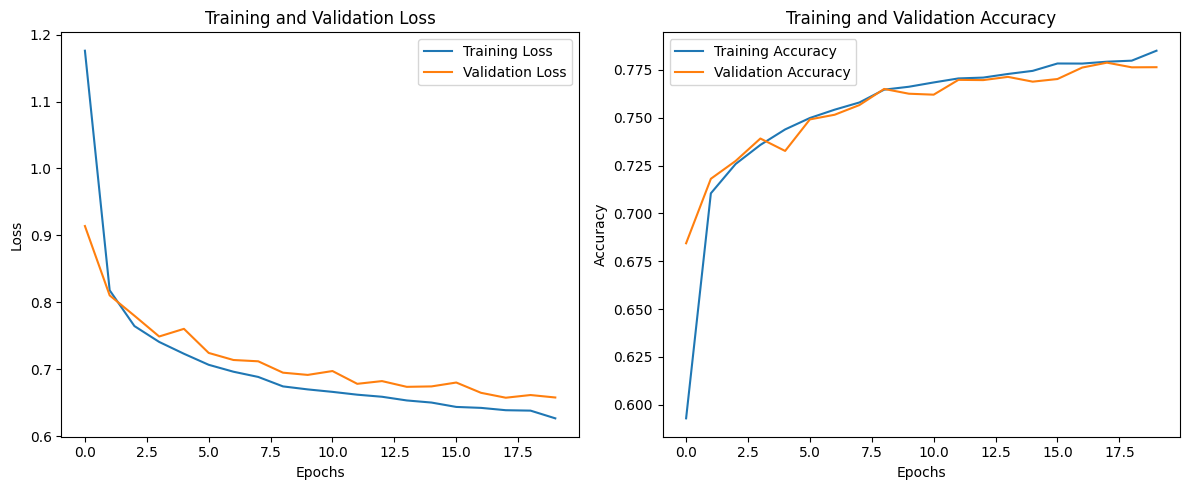

In [30]:
epochs = range(len(train_losses))

plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Classification Model

In [31]:
cl_model.eval()

all_true_labels = []
all_predicted_labels = []

for batch in val_dataloader:
    with torch.no_grad():
        past_times, future_times, past_values, future_values, past_mask, future_mask, label = batch
        label = label.to(device)
        
        logits = cl_model(past_times, past_values, future_times, past_mask)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)

        all_true_labels.extend(label.cpu().numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

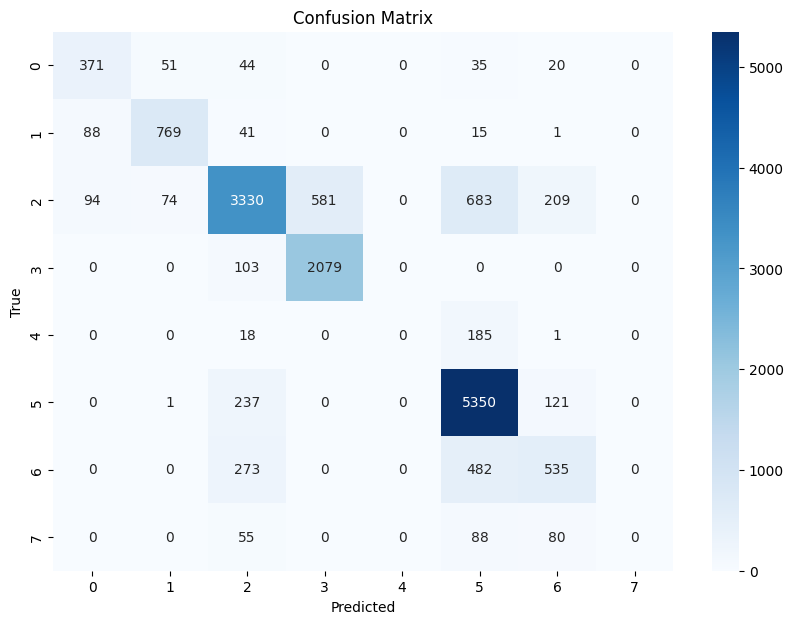

In [32]:
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()